In [4]:
import os
import json
import numpy as np
from glob import glob
from skimage import measure, io
from shapely.geometry import Polygon
import cv2
from matplotlib import pyplot as plt

In [2]:
def read_from_cvat(annotations):
    '''
    Read labels and vertices of each polygon in every section from cvat structure data.
    :param annotations: cvat structure data loaded from json files
    :return: a dictionary containing vertex coordinates organized by section numbers and labels
    '''
    contours = {}
    for annotation in annotations:
        if not annotation['image_id'] in contours.keys():
            contours[annotation['image_id']] = {}
        landmarks = contours[annotation['image_id']]
        if not annotation['category_id'] in landmarks.keys():
            landmarks[annotation['category_id']] = []
        landmarks[annotation['category_id']].extend(annotation['segmentation'])
    return contours

def npy_for_Ng(width,length,z_value,contours):
    '''
    Generate a 3D numpy array including all polygons in CVAT for Neuroglancer.
    :param width: width of thumbnail images
    :param length: length of thumbnail images
    :param z_value: the total section number
    :param contours: a dictionary read from cvat
    :return: a 3D numpy array including all polygons
    '''
    shells = np.zeros([width,length,z_value],dtype='uint8')
    for section in contours.keys():
        shell = np.zeros([width,length],dtype='uint8')
        landmarks = contours[section]
        for structure_id in landmarks.keys():
            for i in range(len(landmarks[structure_id])):
                polygon = np.array(landmarks[structure_id][i])
                polygon = np.c_[polygon[::2], polygon[1::2]]
                cv2.polylines(shell, [polygon.astype(np.int32)], True, structure_id, 3, lineType=8)
        shells[:,:,section-1] = shell
    return shells

In [5]:
# import cvat structure data
JSON_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/masks/MD589'
fn = os.path.join(JSON_PATH, 'outlines.json')
annotation = json.load(open(fn,'r'))
annotations = annotation['annotations']

fn = os.path.join(JSON_PATH, 'landmarks.json')
annotation = json.load(open(fn,'r'))
annotations.extend(annotation['annotations'])

In [6]:
%%time
contours = read_from_cvat(annotations)
shells = npy_for_Ng(1012,1365,447, contours)
#np.save('/data/Shapeology_Files/BstemAtlasDataBackup/ucsd_brain/masks/MD589/MD589.npy', shells)

CPU times: user 4.89 s, sys: 164 ms, total: 5.05 s
Wall time: 5.11 s


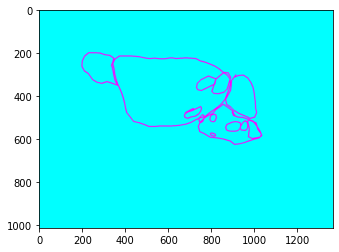

In [8]:
plt.imshow(shells[:,:,150]!=0,cmap='cool')